## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [11]:
half = sym.Rational(1,2)

b_modes = 2
t_modes = 2

# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(b_modes + t_modes +1)

## Create some global parameters
p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing

p.rho_t = mf.ModelSymbol(value = 2.75/1.345,string = 'rho_t') # mass per unit length for the wing
p.s_t = mf.ModelSymbol(value = 1.345,string = 's_t') # chord of wing
p.ratio_fwt = mf.ModelSymbol(value = 0.345/1.345,string = 'sigma') # chord of wing

# main Wing Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')

p.e_0 = mf.ModelSymbol(value = 0.25,string = 'e_0')
p.x_f0 = mf.ModelSymbol(value = 0.5,string = 'x_f0')
#p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c

p.s_0 = mf.ModelSymbol(value = 1,string = 's_0') # chord of wing
#p.s_0 = p.s_t*(1-p.ratio_fwt)# span

## force soome frequencies
#p.f_0 = fm.FwtVariable(2,'f_0') # first Bending mode frequency
#p.EI = (2*sym.pi*p.f_0/sym.Float(3.516))**2*p.rho_0*sym.Abs(p.c)*(p.s_0+p.s_1)**4
p.EI = mf.ModelSymbol(value = 59.375,string = 'EI')

#p.f_1 = fm.FwtVariable(4,'f_1') # first Bending mode frequency
#p.I_0 = p.rho_t*p.c*(half*p.rho_t-p.x_f0)
#p.GJ = (sym.Rational(4,3)*p.f_1*(p.s_0+p.s_1))**2*p.I_0
p.GJ = mf.ModelSymbol(value = 855.625,string = 'GJ')

## FWTD Structural Parameters
p.y_1 = sym.Symbol('y_1')
p.x_1 = sym.Symbol('x_1')

p.e_1 = mf.ModelSymbol(value = 0.25,string = 'e_1')
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c
p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda')


p.s_1 = mf.ModelSymbol(value = 0.345,string = 's_1') # chord of wing
#p.s_1 = p.s_t * p.ratio_fwt # span

p.m_1 = mf.ModelSymbol(value = 0.3,string = 'm_1')
p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho') # density
p.V = mf.ModelSymbol(value = 10,string = 'V') # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g') # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = 1.2,string = 'M_thetadot')


## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0') # C_L of wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1
p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1') # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1') # FWT alphadot


## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point


#### Create Transforms

In [19]:
#get shape functions for main wing
factors = [p.EI**2]*b_modes+[p.GJ**2]*t_modes
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=factors)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_aero_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0).subs({p.x_0:p.x_f0})
wing_tip_frame = wing_aero_frame.subs({p.y_0:p.s_0})
fwt_root_frame = wing_tip_frame.R_x(-p.q[-1])
fwt_com_frame = fwt_root_frame.Translate(0,p.s_1/2,0)

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t/p.c)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx_1)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)


# Create Gravity forces
wing_GravityForces = ef.ContinuousGravityForce(p,wing_aero_frame,
                                                sym.Matrix([0,0,-p.g*p.rho_t/p.c]),(p.x_0,0,p.c),(p.y_0,0,p.s_0))

# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_aero_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)


tau_s0 = tau_0.subs(p.y_0,p.s_0)
alpha_fwt = tau_s0 + p.alpha_1
alphadot_fwt = tau_s0.diff(me.dynamicsymbols._t) + p.alphadot_1

fwt_AeroForces = ef.AeroForce.Generate(p,fwt_root_frame.Translate(0,p.y_1,0),p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)

In [20]:
#Create Composite force
CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces,wing_GravityForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele],CompositeForce)

In [21]:
sm.f.jacobian(p.q)



⎡           2                                                                 
⎢4⋅s₀   6⋅s₀                                                                  
⎢────   ─────    0     0                                                      
⎢  3       3                                                                  
⎢EI      EI                                                                   
⎢                                                                             
⎢    2       3                                                                
⎢6⋅s₀   12⋅s₀                                                                 
⎢─────  ──────   0     0                                                      
⎢   3      3                                                                  
⎢ EI     EI                                                                   
⎢                                                                             
⎢                       2                           

# Setup Numeric Model Parameters


In [22]:
tmax, dt = 5, 0.01

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 18

def arfunc(t,x):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
## Get functions for Fwt AoA and its derivative
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[-1])
FwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa)
DotFwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa.diff(me.dynamicsymbols._t))

# p.alpha_1.value = lambda t,x:FwtAoA(arfunc(t,x),x)
# p.alphadot_1.value = lambda t,x:DotFwtAoA(arfunc(t,x),x)

#p.alpha_1 = mf.ModelExpr(value = fwt_aoa,func = lambda t,x:FwtAoA(arfunc(t,x),x),string = 'alpha_1' )
#p.alphadot_1 = mf.ModelExpr(value = fwt_aoa.diff(t),func = lambda t,x:DotFwtAoA(arfunc(t,x),x),string = 'alphadot_1' )

import types

p.alpha_1.value = fwt_aoa
p.alpha_1._dependent = True
p.alpha_1.GetSub = types.MethodType(lambda self,t,x: fwt_aoa , p.alpha_1)
p.alpha_1._GetValue = types.MethodType(lambda self,t,x : FwtAoA(arfunc(t,x),x) , p.alpha_1)

p.alphadot_1.value = fwt_aoa.diff(time)
p.alphadot_1._dependent = True
p.alphadot_1.GetSub = types.MethodType(lambda self,t,x: self.value , p.alphadot_1)
p.alphadot_1._GetValue = types.MethodType(lambda self,t,x : DotFwtAoA(arfunc(t,x),x), p.alphadot_1)

#p.alpha_1 = mf.ModelExpr(value = fwt_aoa,func = lambda t,x:FwtAoA(arfunc(t,x),x),string = 'alpha_1' )
#p.alphadot_1 = mf.ModelExpr(value = fwt_aoa.diff(t),func = lambda t,x:DotFwtAoA(arfunc(t,x),x),string = 'alphadot_1' )


p.V.value = Vfunc
p.alpha_r.value = arfunc

ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

## Find the fixed point

In [23]:
from scipy.optimize import minimize
def obj(p0):
    v0=np.zeros_like(p0)
    y0 = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
    tup = p.GetNumericTuple(y0,0)
    res = sm.deriv(0,y0,tup)
    return sum((i**2 for i in res)) + res[-2]**2*10
y0 = [0]*p.qs*2
y0[-2] = 0
tup = p.GetNumericTuple(y0,0)
p0=[0]*p.qs
p0[-1] = 1.3
res = minimize(obj,p0)
p0 = res.x
v0=np.zeros_like(p0)
y0 = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
print(y0)

[-55.04748482493738, 0.0, 22.47084317587933, 0.0, -47.94456213959554, 0.0, -89.63183299339754, 0.0, -7.305140300356302, 0.0]


## create masses 

In [24]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

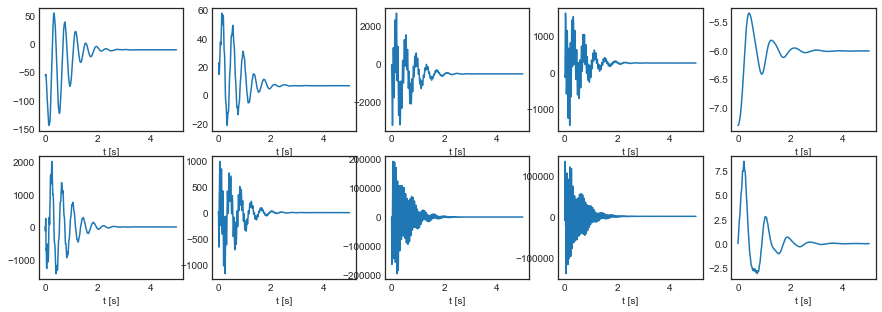

In [25]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

## Create the linearised EoM about some Stationary point

In [81]:
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[-1])

In [82]:


# Linearise the Symbolic model
p.fp.value = [0]*p.qs*2
p.fp.value[-2] = -0.2
sm_subbed = sm.subs(p,{p.alpha_1:p.alpha_1.value,p.alphadot_1:p.alphadot_1.value}).linearise(p)
# Linearise the Parameters
#fwt_aoa_lin = mf.LineariseMatrix(fwt_aoa,p.x,y0)

# Sub it all in
subbed = sm_subbed.subs(p,p.GetSubs(0,p.fp.value,ignore=[p.V,p.fp]))
subbed.ExtForces.Q().jacobian(p.qd)

M_prime = sym.eye(p.qs*2)
M_prime[-p.qs:,-p.qs:]=subbed.M.subs({p.x[i]:p.fp.value[i] for i in range(len(p.x))})

f = (subbed.ExtForces.Q()-subbed.f)

K_prime = sym.zeros(p.qs*2)
K_prime[:p.qs,-p.qs:] = sym.eye(p.qs)
K_prime[-p.qs:,:p.qs] = f.jacobian(p.q)
K_prime[-p.qs:,-p.qs:] = f.jacobian(p.qd)

func = sym.lambdify((p.V,p.fp),(K_prime,M_prime),'numpy')
#tup_prime = 
from scipy.linalg import eig
ev,evec = eig(*func(15,p.fp.value))
ev

array([-17.34759362+571.68334634j, -17.34759362-571.68334634j,
       -14.36827349+327.80175558j, -14.36827349-327.80175558j,
        -2.25002521+115.04541358j,  -2.25002521-115.04541358j,
        -2.08748162 +16.30802842j,  -2.08748162 -16.30802842j,
        -1.22368597  +5.75759133j,  -1.22368597  -5.75759133j])

In [83]:
def objective(p0):
    v0 = np.zeros_like(p0)
    y_f = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
    res = sm.deriv(0,y_f,p.GetNumericTuple(y_f,0))
    return sum((i**2 for i in res))
p.V.value = 0
from scipy.optimize import minimize
p0 = [0]*p.qs
p0[-1] = np.pi/2
res = minimize(objective,p0)
res.x

array([-9.47952632e+03,  3.62724037e+03, -9.95710751e-04,  3.76850255e-04,
        1.58403800e+00])

In [84]:
df = pd.DataFrame(columns=['v','aoa','q','Lambda'])
p.alpha_r.value = np.deg2rad(5)

vs = np.linspace(0,50,101)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    pLast = minimize(objective,[0]*p.qs).x
    v0 = [0]*p.qs
    y0 = [j for i in range(len(p0)) for j in [pLast[i],v0[i]]]
    df = df.append({'aoa' : np.rad2deg(p.alpha_r.value), 'v' : v,'q':y0,'Lambda':np.rad2deg(p.Lambda.value)} , ignore_index=True)
    pLast
data = df

flutdfv2 = pd.DataFrame() 
for i in range(0,len(data)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    evals, evecs = eig(*func(data['v'].iloc[i],data['q'].iloc[i]))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(data['q'].iloc[i])
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    jac_dat['Lambda'] = data['Lambda'].iloc[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,V,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,Lambda
0,-6.180595+0.000000j,-6.180595e+00,0.000000,0.000000,NaN,False,"[(0.15176364903437356+0j), (-0.049744557274616...",0,0.0,-9099.484754,0.0,3500.559564,0.0,-0.001603,0.0,0.000594,0.0,11.465956,0.0,10.0
1,6.180595+0.000000j,6.180595e+00,0.000000,0.000000,NaN,False,"[(0.15176364816799623+0j), (-0.049744559713571...",1,0.0,-9099.484754,0.0,3500.559564,0.0,-0.001603,0.0,0.000594,0.0,11.465956,0.0,10.0
2,0.000000+15.237775j,1.908334e-07,15.237775,2.425167,1.252370e-08,False,"[(2.80895539392876e-09-0.06130583592120093j), ...",2,0.0,-9099.484754,0.0,3500.559564,0.0,-0.001603,0.0,0.000594,0.0,11.465956,0.0,10.0
3,0.000000-15.237775j,1.908334e-07,-15.237775,2.425167,1.252370e-08,False,"[(2.80895539392876e-09+0.06130583592120093j), ...",3,0.0,-9099.484754,0.0,3500.559564,0.0,-0.001603,0.0,0.000594,0.0,11.465956,0.0,10.0
4,0.000000+94.309664j,3.874061e-09,94.309664,15.009849,4.107809e-11,False,[(-2.3524533101472916e-09+0.003025127193305268...,4,0.0,-9099.484754,0.0,3500.559564,0.0,-0.001603,0.0,0.000594,0.0,11.465956,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,-5.843541-113.254810j,-5.843541e+00,-113.254810,18.049040,-5.152786e-02,True,[(8.696524538660783e-05+0.0027541849149915632j...,5,50.0,52238.788330,0.0,-19967.971586,0.0,-565.698814,0.0,282.250964,0.0,0.422910,0.0,10.0
909,-33.825373+321.230588j,-3.382537e+01,321.230588,51.408093,-1.047204e-01,True,[(-0.000180737941852345+0.001974855618164095j)...,6,50.0,52238.788330,0.0,-19967.971586,0.0,-565.698814,0.0,282.250964,0.0,0.422910,0.0,10.0
910,-33.825373-321.230588j,-3.382537e+01,-321.230588,51.408093,-1.047204e-01,True,[(-0.000180737941852345-0.001974855618164095j)...,7,50.0,52238.788330,0.0,-19967.971586,0.0,-565.698814,0.0,282.250964,0.0,0.422910,0.0,10.0
911,-65.202104-568.041520j,-6.520210e+01,-568.041520,91.000238,-1.140353e-01,True,[(4.6807803634412564e-05-0.0008510917062021222...,8,50.0,52238.788330,0.0,-19967.971586,0.0,-565.698814,0.0,282.250964,0.0,0.422910,0.0,10.0


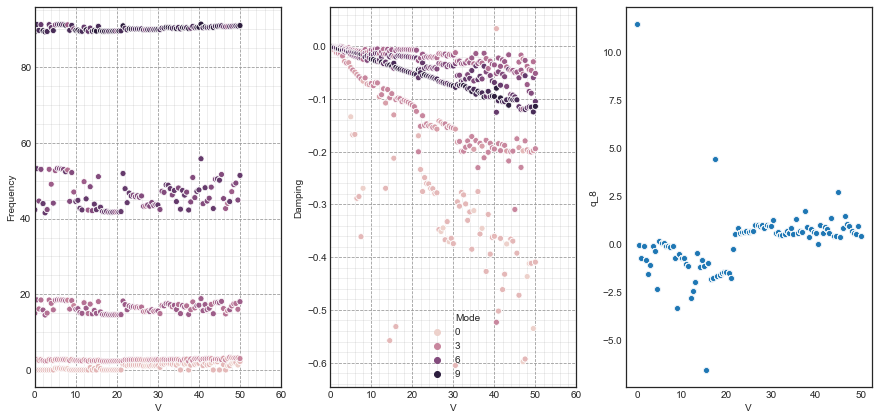

In [85]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
#data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
data = flutdfv2
fig, axes = plt.subplots(1,3,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False)
sns.scatterplot(data=data,x='V',y='Damping',hue='Mode',ax=axes[1])
sns.scatterplot(data=data,x='V',y='q_8',ax=axes[2])


#axes[1].annotate('Flutter Speed Constant',xy=(41, -0.01),  xycoords='data',
#            xytext=(40, -0.1),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#axes[1].annotate('Below flutter speed FWTD stabilises \nthe other mode',xy=(30, -0.05),  xycoords='data',
#            xytext=(20, -0.18),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#axes[1].annotate('Instability has a peak, and its magnitude is a function of mass ratio and flare angle ',xy=(40, 0.2),  xycoords='data',
#            xytext=(-3.5, 0.25),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#sns.scatterplot(data=data,x='V',y='Damping',hue='Mass Ratio',style='Lambda',ax=axes[1],s=10,edgecolor = 'none')
for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))

In [33]:
flutdfv2[flutdfv2['V']==20]

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,V,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,Lambda
350,-1.638713+8.464540j,-1.638713,8.464540,1.372187,-0.190068,True,[(0.0012131863352556405+0.0033834284032325194j...,0,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
351,-2.781110+15.994798j,-2.781110,15.994798,2.583846,-0.171306,True,[(-0.0024034188334594864+0.015542401826201877j...,1,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
352,-2.781110-15.994798j,-2.781110,-15.994798,2.583846,-0.171306,True,[(-0.0024034188334594864-0.015542401826201877j...,2,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
353,-3.132579-116.752544j,-3.132579,-116.752544,18.588432,-0.026821,True,[(-6.000220241895468e-05-0.0016187007944217663...,3,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
354,-3.132579+116.752544j,-3.132579,116.752544,18.588432,-0.026821,True,[(-6.000220241895468e-05+0.0016187007944217663...,4,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
355,-21.164966+336.499322j,-21.164966,336.499322,53.661361,-0.062773,True,[(-0.0002055652636822362+0.0017099112906771407...,5,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
356,-21.164966-336.499322j,-21.164966,-336.499322,53.661361,-0.062773,True,[(-0.0002055652636822362-0.0017099112906771407...,6,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
357,-22.412750+573.119246j,-22.412750,573.119246,91.284483,-0.039077,True,[(-5.33987780850536e-06-0.0008152966830198696j...,7,20.0,0.01851,0.0,-0.006546,0.0,-0.00153,0.0,0.000695,0.0,0.086111,0.0,10.0
